# load libraries

In [9]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
from bs4 import BeautifulSoup
import time
import matplotlib.pyplot as plt
import csv
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
from IPython.display import display
import re
from tqdm.notebook import tqdm
import networkx as nx
import numpy as np
from datetime import datetime, timedelta

# Load csv of countries

In [3]:
countries = pd.read_csv('country_links_pages.csv', index_col=0)
countries.head()

,url,parent_countries,continent,total_pages
0,/en/stamps/Aaland/,['Finland'],Europe,12.0
1,/en/stamps/Aegean-Islands/,"['Italy', 'Italian Occupations', 'Aegean Islan...",Europe,4.0
2,/en/stamps/Calimno/,"['Italy', 'Italian Occupations', 'Aegean Islan...",Europe,1.0
3,/en/stamps/Caso/,"['Italy', 'Italian Occupations', 'Aegean Islan...",Europe,1.0
4,/en/stamps/Castelrosso/,"['Italy', 'Italian Occupations', 'Aegean Islan...",Europe,1.0


# Functions

In [4]:
def get_country_name(driver):
    time.sleep(1)
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    country_name = soup.find('h6', {'id': 'topBlueBarGroupsCatalogLabel'}).text.split("(")[0].strip()
    return country_name
    
def login(driver, url):
    driver.get(url)

    # switch to the iframe
    iframe = WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.ID, 'sp_message_iframe_1117340')))
    driver.switch_to.frame(iframe)

    # accept the cookies
    try:
        wait = WebDriverWait(driver, 20)  # increase wait time to 20 seconds
        button = wait.until(EC.presence_of_element_located((By.XPATH, '//button[@title="Accept" and @aria-label="Accept"]')))  # use more specific XPath
        button.click()
    except TimeoutException:
        print("Could not find the Accept button.")

    driver.switch_to.default_content()

    time.sleep(1)
    # click the login button
    driver.find_element(By.ID, 'signIn').click()
    time.sleep(1)
    # enter username
    driver.find_element(By.ID, 'username').send_keys('timo1024')
    # enter password
    driver.find_element(By.ID, 'password').send_keys('StampworldSecure')
    # click the login button
    driver.find_element(By.ID, 'loginBtn').click()
    time.sleep(1)

def get_information(driver, country_name, parent_countries, continent):

    columns = ['ID', 'SetDescription', 'Date', 'Year', 'Watermark', 'Sheetsize', 'Design', 'Engraving', 'Performation', 'Type', 'Value', 'Color', 'Description', 'StampsIssued', 'Mint', 'Unused', 'Used', 'LetterFDC', 'Currency', 'GroupID', 'Country', 'ParentCountries', 'Continent']
    df = pd.DataFrame(columns=columns)

    soup = BeautifulSoup(driver.page_source, 'html.parser')

    # get all ids which start with "group_box_"
    ids = [div['id'] for div in soup.find_all('div', {'id': re.compile(r'group_box_')})]

    # loop over ids
    for id in ids:
        # get the id
        GroupID = id.split('_')[-1]
        # get the div and its content
        div = soup.find('div', {'id': id})

        # get the text in the a tag in the div with class table_header
        divHeader = div.find('div', {'class': 'table_header'})
        setDescriptionFull = divHeader.find('a').text.strip()

        # get the year from the setDescriptionFull
        Year = setDescriptionFull.split(' ')[0].strip()

        setDescriptionPart = setDescriptionFull.split(Year)[1:]
        SetDescription = ' '.join(setDescriptionPart).strip()


        setInformation = divHeader.find('p').text.strip().split('\n')
        # strip all elements
        setInformation = [x.strip() for x in setInformation if x.strip() != '']
        Date = setInformation[0]
        Watermark = [x for x in setInformation if 'WM' in x]
        if len(Watermark) > 0:
            Watermark = ' '.join(Watermark[0].split(' ')[1:]).strip()
        else:
            Watermark = ''
        Sheetsize = [x for x in setInformation if 'Sheetsize' in x]
        if len(Sheetsize) > 0:
            Sheetsize = ' '.join(Sheetsize[0].split(' ')[1:]).strip()
        else:
            Sheetsize = ''
        Design = [x for x in setInformation if 'Design' in x]
        if len(Design) > 0:
            Design = ' '.join(Design[0].split(' ')[1:]).strip()
        else:
            Design = ''
        Engraving = [x for x in setInformation if 'Engraving' in x]
        if len(Engraving) > 0:
            Engraving = ' '.join(Engraving[0].split(' ')[1:]).strip()
        else:
            Engraving = ''
        Performation = [x for x in setInformation if 'Perforation' in x]
        if len(Performation) > 0:
            Performation = ' '.join(Performation[0].split(' ')[1:]).strip()
        else:
            Performation = ''

        # get column names
        # get list of all th with scope col
        colnames = []
        ths = div.find_all('th', {'scope': 'col'})[1:]
        for th in ths:
            # print(th.text.strip())
            # if content of th is a string append it. if it is a img tag append the alt attribute and if there is nothing in there at all append "null"
            if th.find('img') != None:
                colnames.append(th.find('img')['alt'])
            elif th.text.strip() != '':
                colnames.append(th.text.strip())
            else:
                colnames.append('null')

        # make the first of the last "null" entries "Currency"
        colnames[-5] = 'Currency'
        indexType = colnames.index('Type')
        indexValue = colnames.index('D')
        indexColor = colnames.index('Color')
        indexDescription = colnames.index('Description')
        indexStampsIssued = colnames.index('Stamps Issued')
        indexMint = colnames.index('Mint Condition')
        indexUnused = colnames.index('Unused')
        indexUsed = colnames.index('Used')
        indexLetterFDC = colnames.index('Letter/FDC')
        indexCurrency = colnames.index('Currency')

        # get list of stamp rows
        stamps = div.find_all('tr', {'class': 'stamp_tr', 'data-stamp-group-id': GroupID})
        # loop over stamps
        for stamp in stamps:
            # get the first th and there the a tag and the id from it
            ID = stamp.find('th').find('a')['id']
            # get all the tds
            tds = stamp.find_all('td')

            # get the type
            Type = tds[indexType].text.strip()
            # get the value
            Value = tds[indexValue].text.strip()
            # get the color
            Color = tds[indexColor].text.strip()
            # get the description
            Description = tds[indexDescription].text.strip()
            # get the stamps issued
            StampsIssued = tds[indexStampsIssued].text.strip()
            # get the mint
            Mint = tds[indexMint].text.strip()
            # get the unused
            Unused = tds[indexUnused].text.strip()
            # get the used
            Used = tds[indexUsed].text.strip()
            # get the letterfdc
            LetterFDC = tds[indexLetterFDC].text.strip()
            # get the currency
            Currency = tds[indexCurrency].text.strip()

            # append the data to the dataframe
            df = pd.concat([df, pd.DataFrame([[ID, SetDescription, Date, Year, Watermark, Sheetsize, Design, Engraving, Performation, Type, Value, Color, Description, StampsIssued, Mint, Unused, Used, LetterFDC, Currency, GroupID, country_name, parent_countries, continent]], columns=columns)], ignore_index=True)

    return df



In [6]:
link

'https://www.stampworld.com/en/stamps/France/?page=48'

# main

In [21]:
# split country rows in 31 seperate dataframes
countries_split = np.array_split(countries, 62)

# for single indeces
indeces = [61]
counter = 1

# loop over all dataframes
# for i, countries_subset in enumerate(countries_split):
for i in indeces:
    print(f"Processing countries subset nr. {i}")
    countries_subset = countries_split[i]
    try:
        options = Options()
        options.headless = False
        driver = webdriver.Firefox(options=options)
        driver.set_page_load_timeout(60)

        # login
        login(driver, 'https://www.stampworld.com/en/')
        time.sleep(1)

        columns = ['ID', 'SetDescription', 'Date', 'Year', 'Watermark', 'Sheetsize', 'Design', 'Engraving', 'Performation', 'Type', 'Value', 'Color', 'Description', 'StampsIssued', 'Mint', 'Unused', 'Used', 'LetterFDC', 'Currency', 'GroupID', 'Country', 'ParentCountries', 'Continent']
        df = pd.DataFrame(columns=columns)

        for index, row in tqdm(countries_subset.iterrows(), total=countries_subset.shape[0], desc="Processing"):
            link = f"https://www.stampworld.com{row.url}"

            # link = f"https://www.stampworld.com{row.url}"
            try:
                driver.get(link)
            except TimeoutException:
                print("TimeoutException")
                continue
            country_name = get_country_name(driver)


            # loop over all pages from 1 to the last page
            for page in range(1, int(row.total_pages)+1):
                # if page is multiple of 40 relogin to website (close driver and open new one)
                if counter % 40 == 0:
                    driver.quit()
                    driver = webdriver.Firefox(options=options)
                    driver.set_page_load_timeout(600)
                    login(driver, 'https://www.stampworld.com/en/')

                time.sleep(1)
                # get the link of the page
                link = f"https://www.stampworld.com{row.url}?page={page}"

                # Set a timeout for the operation
                timeout = timedelta(minutes=1)
                start_time = datetime.now()

                while datetime.now() - start_time < timeout:
                    try:
                        driver.get(link)
                        time.sleep(1)
                        break  # If successful, break the loop
                    except TimeoutException:
                        print("TimeoutException, retrying...")
                        continue
                # driver.get(link)

                new_rows = get_information(driver, country_name, row.parent_countries, row.continent)
                df = pd.concat([df, new_rows], ignore_index=True)

                counter += 1

        driver.quit()

        df.to_csv(f"all_countries_{i}.csv")
    except Exception as e:
        print(e)
        try:
            driver.quit()
        except:
            print("Could not quit driver.")
            continue
        continue


C:\Users\Robin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Processing countries subset nr. 61


Processing:   0%|          | 0/19 [00:00<?, ?it/s]

In [22]:
df

,ID,SetDescription,Date,Year,Watermark,Sheetsize,Design,Engraving,Performation,Type,...,StampsIssued,Mint,Unused,Used,LetterFDC,Currency,GroupID,Country,ParentCountries,Continent
0,a_s_0001,"Netherlands New Guinea Stamps Overprinted ""UNTEA""",1. October,1962,None,,,,12½ x 12,A,...,,0.75,-,0.50,-,EUR,267409,UNTEA,['Papua New Guinea'],Oceania
1,a_s_0002,"Netherlands New Guinea Stamps Overprinted ""UNTEA""",1. October,1962,None,,,,12½ x 12,B,...,,1.50,-,0.50,-,EUR,267409,UNTEA,['Papua New Guinea'],Oceania
2,a_s_0003,"Netherlands New Guinea Stamps Overprinted ""UNTEA""",1. October,1962,None,,,,12½ x 12,C,...,,1.50,-,0.50,-,EUR,267409,UNTEA,['Papua New Guinea'],Oceania
3,a_s_0004,"Netherlands New Guinea Stamps Overprinted ""UNTEA""",1. October,1962,None,,,,12½ x 12,D,...,,1.50,-,1.00,-,EUR,267409,UNTEA,['Papua New Guinea'],Oceania
4,a_s_0005,"Netherlands New Guinea Stamps Overprinted ""UNTEA""",1. October,1962,None,,,,12½ x 12,E,...,,1.50,-,0.75,-,EUR,267409,UNTEA,['Papua New Guinea'],Oceania
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16856,a_s_0556,Birds - English Version,27. February,1980,5,,,,14¼ x 14,NX,...,,1.50,-,1.50,-,EUR,150800,New Hebrides,['Vanuatu'],Oceania
16857,a_s_0557,Birds - French Version,27. February,1980,None,,,,14¼ x 14,NU1,...,,1.50,-,0.50,-,EUR,150801,New Hebrides,['Vanuatu'],Oceania
16858,a_s_0558,Birds - French Version,27. February,1980,None,,,,14¼ x 14,NV1,...,,1.50,-,1.00,-,EUR,150801,New Hebrides,['Vanuatu'],Oceania
16859,a_s_0559,Birds - French Version,27. February,1980,None,,,,14¼ x 14,NW1,...,,2.00,-,2.00,-,EUR,150801,New Hebrides,['Vanuatu'],Oceania


## merge all dfs

In [28]:
# load all csv files (all_countries_0.csv to all_countries_61.csv)
dfs = []
for i in range(62):
    df = pd.read_csv(f"all_countries_{i}.csv", index_col=0)
    dfs.append(df)
# merge all dataframes
df = pd.concat(dfs, ignore_index=True)
df.to_csv("all_countries.csv")

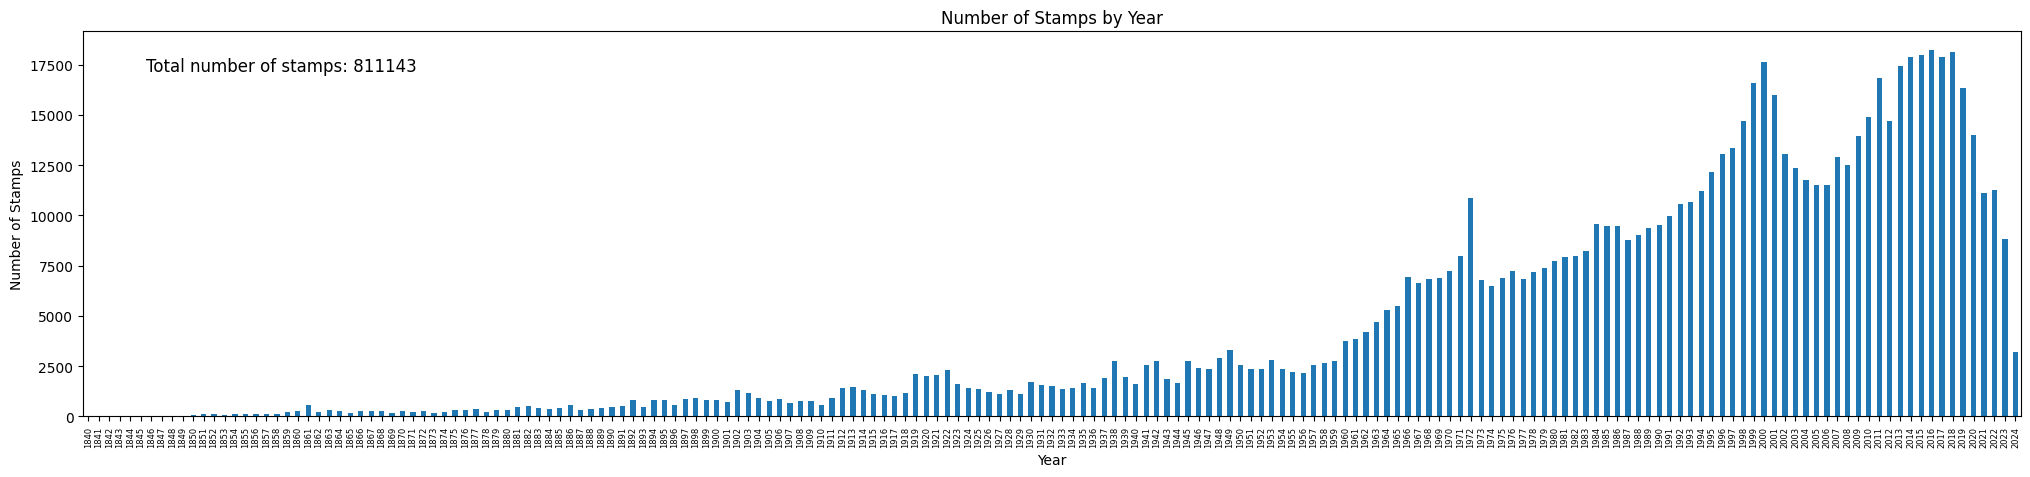

In [46]:
df.head()

# make plot to see stamps by year
df['Year'] = df['Year'].astype(int)
df['Year'].value_counts().sort_index().plot(kind='bar', figsize=(25, 5))
plt.xlabel('Year')
plt.ylabel('Number of Stamps')
plt.title('Number of Stamps by Year')
# make x labels smaller
plt.xticks(fontsize=6)

# print the total number of stamps in top left
plt.text(0.15, 0.8, f"Total number of stamps: {df.shape[0]}", fontsize=12, transform=plt.gcf().transFigure)

plt.show()

In [34]:
# print total number of stamps
print(f"Total number of stamps: {df.shape[0]}")

Total number of stamps: 811143
